In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.font_manager as font_manager
import os

!pip install numpy rclpy rosbag2_py rosidl-runtime-py

import numpy as np
import rosbag2_py
import rclpy
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from dynus_interfaces.msg import Goal

# font
font = font_manager.FontProperties()
font.set_family('serif')
plt.rcParams.update({"text.usetex": True})
plt.rcParams["font.family"] = "Times New Roman"
font.set_size(40)

In [6]:
def get_header_initialized_dict(file, algo_folder_path):

    dict = {}

    # Print the file path
    file_path = algo_folder_path + "/" + file

    # Load the CSV file
    raw_data = pd.read_csv(file_path)

    # Get headers
    headers = raw_data.columns
    
    # Initialize the dictionary
    for header in headers:
        dict[header] = []

    return dict

def get_data(folder_path, algorithm):

    """
    Get the data from the CSV files in the folder
    """
    
    # Get the files in the folder
    algo_folder_path = folder_path + algorithm

    # Get all the CSV files in the folder
    files = [f for f in listdir(algo_folder_path) if isfile(join(algo_folder_path, f))]
    
    # Initialize the dictionary to store the data
    float_data = get_header_initialized_dict(files[0], algo_folder_path)

    # Convert the data to float
    for file in files:

        # Print the file path
        file_path = algo_folder_path + "/" + file

        # Load the CSV file
        raw_data = pd.read_csv(file_path)

        # Get headers
        headers = raw_data.columns

        raw_data_dict = {}
        for header in headers:
            raw_data_dict[header] = None

        # Store the data in the dictionary
        for header in headers:
            raw_data_dict[header] = raw_data[header].values

        for key in raw_data_dict:
            if key == 'Planner':
                continue
            float_data[key].extend(raw_data_dict[key].astype(float).tolist())
    
            # If there's any nan data - FASTER approach sometimes have nan values in Dynamic A* - remove them
            if (np.isnan(float_data[key]).any()):
                float_data[key] = [x for x in float_data[key] if not np.isnan(x)] 

    return float_data

def get_metrics(float_data):
    """
    Get the average, min, max, and std of the data
    """

    # Initialize the dictionary
    avg_data = {}
    min_data = {}
    max_data = {}
    std_data = {}

    # Get average, min, max, and std of the data
    for key in float_data:

        if key == 'Planner':
            continue

        avg_data[key] = np.mean(float_data[key])
        min_data[key] = np.min(float_data[key])
        max_data[key] = np.max(float_data[key])
        std_data[key] = np.std(float_data[key])

    return avg_data, min_data, max_data, std_data

def filter_data(data):

    # Cost (final node's g): if global planning time is 0.0 and the result is 0, then it's after reaching the goal
    exclude_indices = [i for i, x in enumerate(data["Total replanning time [ms]"]) if x == 0.0 or data['Result'][i] == 0]

    print(exclude_indices)

    # Filter out the failures
    
    # Get the keys
    keys = list(data.keys())
    for key in keys:
        data[key] = [x for i, x in enumerate(data[key]) if i not in exclude_indices]

    return data



In [4]:
# Define the file path
algorithms = ["dgp", "dastar"]

# Get the data
for algorithm in algorithms:
    folder_path = f"/media/kkondo/T7/dynus/tro_paper/yaw_optimization/{algorithm}/csv/"
    float_data = get_data(folder_path, "dynus")
    float_data = filter_data(float_data)
    avg_data, min_data, max_data, std_data = get_metrics(float_data)

    for key in float_data:

        if key == 'Planner':
            print("*******************************************************************")
            print("Algorithm: ", algorithm)
            print("*******************************************************************")
            continue

        print(key, avg_data[key], min_data[key], max_data[key], std_data[key])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [2]:
def read_ros2_bag(bag_path, topic_name, message_type):
    """
    Reads a ROS 2 bag file and extracts messages from a specified topic.

    Args:
        bag_path (str): Path to the ROS 2 bag file.
        topic_name (str): The name of the topic to extract data from.
        message_type (str): The message type as a string (e.g., "geometry_msgs/msg/Twist").

    Returns:
        list: A list of messages from the specified topic.
    """
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format="cdr", output_serialization_format="cdr"
    )

    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)

    all_topics = reader.get_all_topics_and_types()
    topic_names = [topic.name for topic in all_topics]

    topic_found = any(t == topic_name for t in topic_names)
    if not topic_found:
        print(f"Topic '{topic_name}' not found in the bag.")
        return []

    # Resolve the message type dynamically
    msg_type = get_message(message_type)

    data = []
    while reader.has_next():
        topic, serialized_msg, _ = reader.read_next()
        if topic == topic_name:
            msg = deserialize_message(serialized_msg, msg_type)
            data.append(msg)

    return data

def process_goal_data(messages, start_time, terminal_goal):
    """
    Processes goal data to extract desired values and computes averages.

    Args:
        messages (list): List of ROS 2 messages.

    Returns:
        np.ndarray: Array of extracted values.
    """
    
    # Get the very first msg's time stamp
    # start_time = messages[0].header.stamp.sec + messages[0].header.stamp.nanosec * 1e-9

    # Extract goal positions
    positions = [[msg.p.x, msg.p.y, msg.p.z] for msg in messages]

    # Extract velocities
    velocities = [np.linalg.norm(np.array([msg.v.x, msg.v.y, msg.v.z])) for msg in messages]

    # Extract accelerations
    accelerations = [np.linalg.norm(np.array([msg.a.x, msg.a.y, msg.a.z])) for msg in messages]

    # Extract jerk
    jerks = [np.linalg.norm(np.array([msg.j.x, msg.j.y, msg.j.z])) for msg in messages]

    # go through the messages and find the time where the goal is reached (the distance is less than 0.1)
    for i, msg in enumerate(messages):
        dist = np.linalg.norm(np.array([msg.p.x - terminal_goal[0], msg.p.y - terminal_goal[1], msg.p.z - terminal_goal[2]]))
        if dist < 1.0:
            end_time = msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9
            break
            
    # Get the total time
    total_time = end_time - start_time

    return np.array(positions), np.array(velocities), np.array(accelerations), np.array(jerks), total_time

def plot_velocity_histogram(velocities, bins=30, title="Velocity Profile", xlabel="Velocity (m/s)", ylabel="Frequency", output_file=None):
    """
    Plots a histogram of the velocity profile.

    Args:
        velocities (np.ndarray): Array of velocity values.
        bins (int): Number of bins for the histogram. Default is 30.
        title (str): Title of the plot. Default is "Velocity Profile".
        xlabel (str): Label for the x-axis. Default is "Velocity (m/s)".
        ylabel (str): Label for the y-axis. Default is "Frequency".
        output_file (str): If provided, saves the plot to this file. Default is None.
    """
    # Create the histogram
    plt.figure(figsize=(10, 6))
    weights = velocities / len(velocities)
    plt.hist(velocities, weights=weights, bins=bins, color="skyblue", edgecolor="black", alpha=0.7)
    
    # Add titles and labels
    plt.title(title, fontproperties=font, weight='bold')
    plt.xlabel(xlabel, fontproperties=font)
    plt.ylabel(ylabel, fontproperties=font)
    plt.xticks(fontproperties=font)
    plt.yticks(fontproperties=font)
    
    # Grid and styling
    plt.grid(color='gray', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    
    # Show or save the plot
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        print(f"Plot saved as {output_file}")
    else:
        plt.show()

In [3]:
# Get DGP's data 
base_path = "/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus"
num_bags = 10
topic_name = "/NX01/goal"
message_type = "dynus_interfaces/msg/Goal"  # Update with your message type
term_goal_topic_name = "/NX01/term_goal"
term_goal_message_type = "geometry_msgs/msg/PoseStamped"  # Update with your message type

# Initialize arrays to store data
dgp_pos_array = np.array([])
dgp_vel_array = np.array([])
dgp_accel_array = np.array([])
dgp_jerk_array = np.array([])
dgp_travel_time_array = np.array([])
dgp_path_length_array = np.array([])

for i in range(num_bags):
    bag_path = f"{base_path}/num_{i}"
    print(f"processing bag: {bag_path}")

    # Get simulation start time as the terminal goal sent time
    terminal_goal_messages = read_ros2_bag(bag_path, term_goal_topic_name, term_goal_message_type)
    start_time = terminal_goal_messages[0].header.stamp.sec + terminal_goal_messages[0].header.stamp.nanosec * 1e-9

    # Read the bag and extract data
    messages = read_ros2_bag(bag_path, topic_name, message_type)

    if not messages:
        print(f"No messages found or topic does not exist in {bag_path}.")
    else:
        
        # Process data
        pos, vel, accel, jerk, travel_time = process_goal_data(messages, start_time, terminal_goal=[25.0, 0.0, 3.0])

        # Append to the arrays
        dgp_pos_array = np.append(dgp_pos_array, pos)
        dgp_vel_array = np.append(dgp_vel_array, vel)
        dgp_accel_array = np.append(dgp_accel_array, accel)
        dgp_jerk_array = np.append(dgp_jerk_array, jerk)
        dgp_travel_time_array = np.append(dgp_travel_time_array, travel_time)
        print("travel_time", travel_time)

        # compute path length
        path_length = 0
        for i in range(len(pos)-1):
            path_length += np.linalg.norm(pos[i+1] - pos[i])
        dgp_path_length_array = np.append(dgp_path_length_array, path_length)

print("ave dgp_travel_time_array: ", np.mean(dgp_travel_time_array))
print("ave dgp_path_length_array: ", np.mean(dgp_path_length_array))

processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_0


[INFO] [1745277068.317805036] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_0/num_0_0.db3' for READ_ONLY.
[INFO] [1745277070.975583218] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_0/num_0_0.db3' for READ_ONLY.


travel_time 12.477901697158813
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_1


[INFO] [1745277072.010954805] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_1/num_1_0.db3' for READ_ONLY.
[INFO] [1745277074.639491887] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_1/num_1_0.db3' for READ_ONLY.


travel_time 17.377260208129883
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_2


[INFO] [1745277075.843485982] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_2/num_2_0.db3' for READ_ONLY.
[INFO] [1745277078.604098819] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_2/num_2_0.db3' for READ_ONLY.


travel_time 15.516296863555908
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_3


[INFO] [1745277079.805144118] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_3/num_3_0.db3' for READ_ONLY.
[INFO] [1745277082.788244351] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_3/num_3_0.db3' for READ_ONLY.


travel_time 17.286553382873535
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_4


[INFO] [1745277084.377524212] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_4/num_4_0.db3' for READ_ONLY.
[INFO] [1745277087.549995633] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_4/num_4_0.db3' for READ_ONLY.


travel_time 18.5765597820282
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_5


[INFO] [1745277088.879380797] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_5/num_5_0.db3' for READ_ONLY.
[INFO] [1745277091.885411013] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_5/num_5_0.db3' for READ_ONLY.


travel_time 13.791644811630249
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_6


[INFO] [1745277093.022881534] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_6/num_6_0.db3' for READ_ONLY.
[INFO] [1745277095.490397439] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_6/num_6_0.db3' for READ_ONLY.


travel_time 13.441900730133057
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_7


[INFO] [1745277096.610753571] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_7/num_7_0.db3' for READ_ONLY.
[INFO] [1745277099.536296294] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_7/num_7_0.db3' for READ_ONLY.


travel_time 15.672799587249756
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_8


[INFO] [1745277100.859442436] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_8/num_8_0.db3' for READ_ONLY.
[INFO] [1745277103.402083707] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_8/num_8_0.db3' for READ_ONLY.


travel_time 13.334747076034546
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_9


[INFO] [1745277104.530826025] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_9/num_9_0.db3' for READ_ONLY.
[INFO] [1745277107.366281921] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dgp/bags/dynus/num_9/num_9_0.db3' for READ_ONLY.


travel_time 17.157532215118408
ave dgp_travel_time_array:  15.463319635391235
ave dgp_path_length_array:  58.56678203514402


In [4]:
# Get DGP's data 
base_path = "/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus"
num_bags = 10
topic_name = "/NX01/goal"
message_type = "dynus_interfaces/msg/Goal"  # Update with your message type
term_goal_topic_name = "/NX01/term_goal"
term_goal_message_type = "geometry_msgs/msg/PoseStamped"  # Update with your message type

# Initialize arrays to store data
dastar_pos_array = np.array([])
dastar_vel_array = np.array([])
dastar_accel_array = np.array([])
dastar_jerk_array = np.array([])
dastar_travel_time_array = np.array([])
dastar_path_length_array = np.array([])

for i in range(num_bags):
    bag_path = f"{base_path}/num_{i}"
    print(f"processing bag: {bag_path}")

    # Get simulation start time as the terminal goal sent time
    terminal_goal_messages = read_ros2_bag(bag_path, term_goal_topic_name, term_goal_message_type)
    start_time = terminal_goal_messages[0].header.stamp.sec + terminal_goal_messages[0].header.stamp.nanosec * 1e-9

    # Read the bag and extract data
    messages = read_ros2_bag(bag_path, topic_name, message_type)

    if not messages:
        print(f"No messages found or topic does not exist in {bag_path}.")
    else:
        
        # Process data
        pos, vel, accel, jerk, travel_time = process_goal_data(messages, start_time, terminal_goal=[25.0, 0.0, 3.0])

        # Append to the arrays
        dastar_pos_array = np.append(dastar_pos_array, pos)
        dastar_vel_array = np.append(dastar_vel_array, vel)
        dastar_accel_array = np.append(dastar_accel_array, accel)
        dastar_jerk_array = np.append(dastar_jerk_array, jerk)
        dastar_travel_time_array = np.append(dastar_travel_time_array, travel_time)
        print("travel_time", travel_time)

        # compute path length
        path_length = 0
        for i in range(len(pos)-1):
            path_length += np.linalg.norm(pos[i+1] - pos[i])
        dastar_path_length_array = np.append(dastar_path_length_array, path_length)

print("ave dastar_travel_time_array: ", np.mean(dastar_travel_time_array))
print("ave dastar_path_length_array: ", np.mean(dastar_path_length_array))

processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_0


[INFO] [1745277108.711034657] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_0/num_0_0.db3' for READ_ONLY.
[INFO] [1745277111.577801056] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_0/num_0_0.db3' for READ_ONLY.


travel_time 15.613257884979248
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_1


[INFO] [1745277112.870741151] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_1/num_1_0.db3' for READ_ONLY.
[INFO] [1745277115.836976025] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_1/num_1_0.db3' for READ_ONLY.


travel_time 15.635544776916504
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_2


[INFO] [1745277117.210215484] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_2/num_2_0.db3' for READ_ONLY.
[INFO] [1745277119.736419436] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_2/num_2_0.db3' for READ_ONLY.


travel_time 13.683745384216309
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_3


[INFO] [1745277120.845407463] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_3/num_3_0.db3' for READ_ONLY.
[INFO] [1745277123.862591576] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_3/num_3_0.db3' for READ_ONLY.


travel_time 17.779738664627075
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_4


[INFO] [1745277125.088588341] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_4/num_4_0.db3' for READ_ONLY.
[INFO] [1745277127.896316138] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_4/num_4_0.db3' for READ_ONLY.


travel_time 16.58804941177368
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_5


[INFO] [1745277129.153392146] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_5/num_5_0.db3' for READ_ONLY.
[INFO] [1745277132.140594709] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_5/num_5_0.db3' for READ_ONLY.


travel_time 16.266948461532593
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_6


[INFO] [1745277133.447434101] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_6/num_6_0.db3' for READ_ONLY.
[INFO] [1745277136.636762745] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_6/num_6_0.db3' for READ_ONLY.


travel_time 17.16624140739441
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_7


[INFO] [1745277137.884344817] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_7/num_7_0.db3' for READ_ONLY.
[INFO] [1745277140.650042828] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_7/num_7_0.db3' for READ_ONLY.


travel_time 14.909933805465698
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_8


[INFO] [1745277141.760495847] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_8/num_8_0.db3' for READ_ONLY.
[INFO] [1745277145.125489576] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_8/num_8_0.db3' for READ_ONLY.


travel_time 17.15122389793396
processing bag: /media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_9


[INFO] [1745277146.586815323] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_9/num_9_0.db3' for READ_ONLY.
[INFO] [1745277149.961082493] [rosbag2_storage]: Opened database '/media/kkondo/T7/dynus/tro_paper/yaw_optimization/dastar/bags/dynus/num_9/num_9_0.db3' for READ_ONLY.


travel_time 21.238579511642456
ave dastar_travel_time_array:  16.603326320648193
ave dastar_path_length_array:  57.70162062724752


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

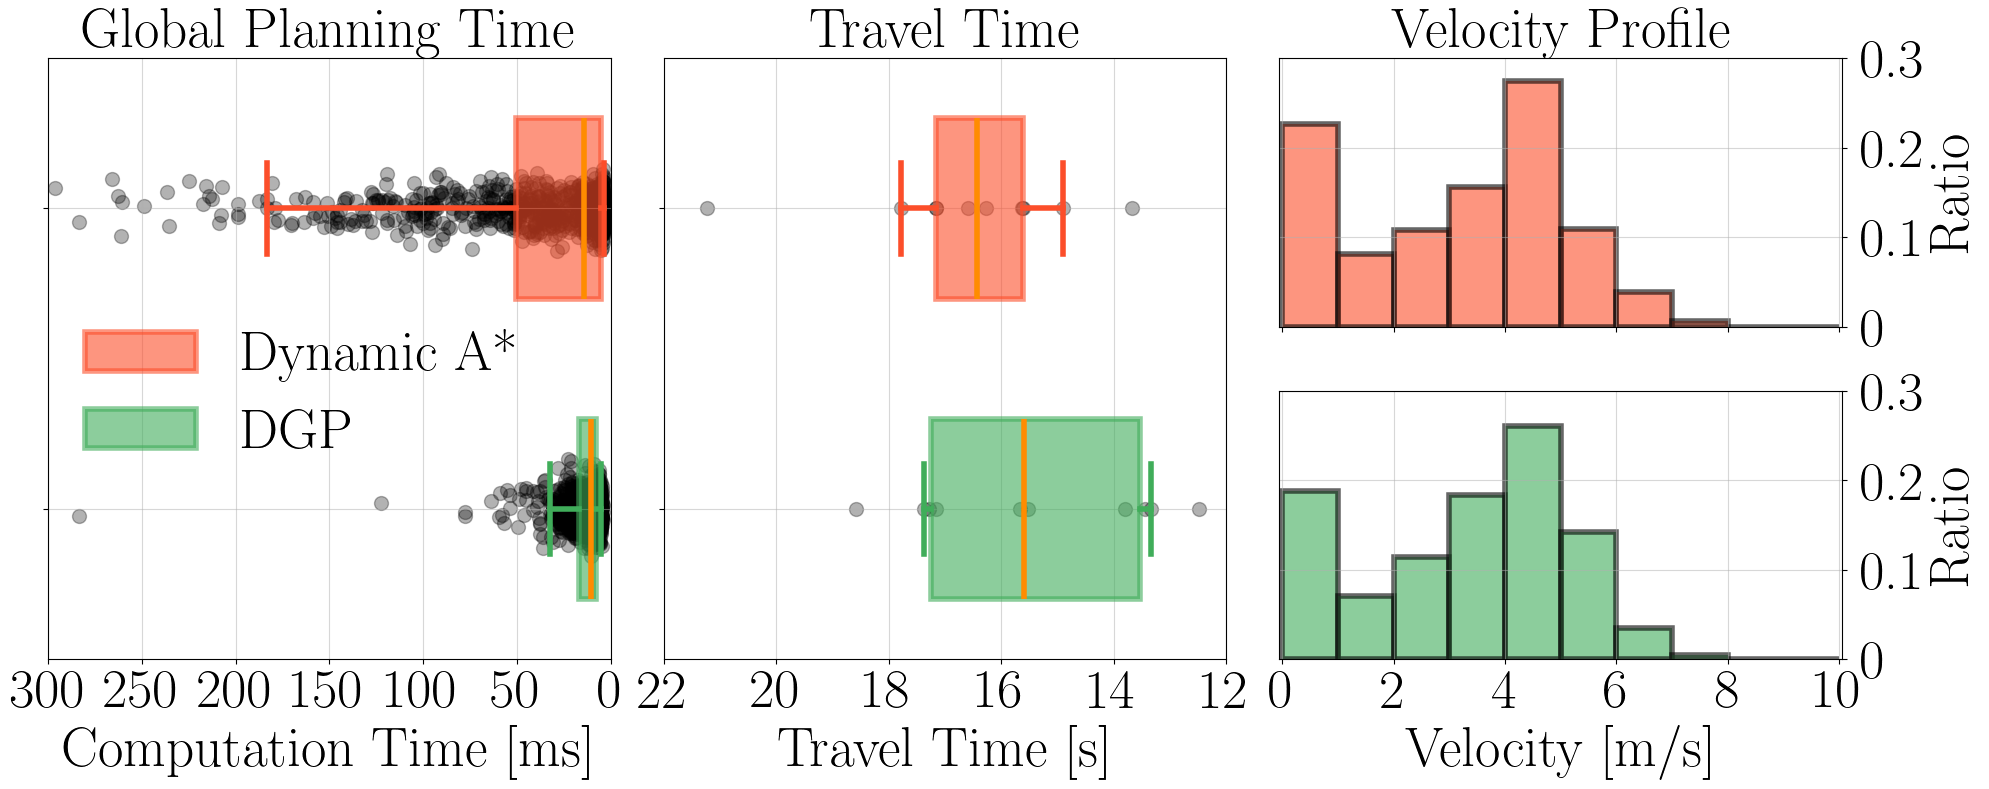

Average travel time for DGP:  15.463319635391235
Average travel time for Dynamic A*:  16.603326320648193


In [12]:
# Box plot data (placeholder; replace with your computation time data)
algorithms = ["dgp", "dastar"]
parent_folder_path = "/media/kkondo/T7/dynus/tro_paper/yaw_optimization/"
dgp_color = "#40AD5A"
dastar_color = "#FC4E2A"

# Create figure
figsize_x = 20
figsize_y = figsize_x / 2.5 # Find golden ratio
fig = plt.figure(figsize=(figsize_x, figsize_y))

# Left: Box Plot for Computation Times
ax_box = fig.add_subplot(1, 3, 1)

header_to_plot = "Global Planning Time [ms]"

idx = 0
handles = []  # For the legend
labels = []  # Corresponding labels
dgp_label_added = False
dastar_label_added = False

for algorithm in algorithms:

    if algorithm == "dgp":
        folder_path = parent_folder_path + "dgp/csv/"
    elif algorithm == "dastar":
        folder_path = parent_folder_path + "dastar/csv/"

    float_data = get_data(folder_path, "dynus")
    float_data = filter_data(float_data)
    headers = list(float_data.keys())

    for i in range(1, len(headers)):  # Adjusted for simulated data structure
        if headers[i] == header_to_plot:
            data_points = float_data[headers[i]]
            # Boxplot
            box = ax_box.boxplot(data_points, positions=[idx], widths=0.6, patch_artist=True, showfliers=False, vert=False, whis=[3, 97])
            for element in ['whiskers', 'fliers', 'means', 'caps']:
                plt.setp(box[element], color=dgp_color if algorithm == "dgp" else dastar_color, linewidth=4)
            for patch in box['boxes']:
                color = dgp_color if algorithm == "dgp" else dastar_color
                patch.set(facecolor=color, alpha=0.6)
                patch.set(color=color, linewidth=4, edgecolor=color)
                # Add legend handle for the first box of each algorithm
                if (algorithm == "dgp" and not dgp_label_added) or (algorithm == "dastar" and not dastar_label_added):
                    handles.append(patch)
                    labels.append("DGP" if algorithm == "dgp" else "Dynamic A*")
            for median_line in box['medians']:
                median_line.set_color('darkorange')  # Median line color
                median_line.set_linewidth(4)  # Thicker median line

            # Add jittered data points
            jitter = np.random.normal(0, 0.05, len(data_points))  # Small random offset for y-axis
            ax_box.scatter(data_points, [idx + jitter_val for jitter_val in jitter], color='black', alpha=0.3, s=100)
            idx += 1

# ax_box.set_xlim([-20, 200])  # Set x-axis limits
# ax_box.set_xticks(range(0, 201, 50), ["0", "50", "100", "150", "200"], fontproperties=font)
ax_box.set_xlim([0, 300])  # Set x-axis limits
ax_box.set_xticks(range(0, 301, 50), ["0", "50", "100", "150", "200", "250", "300"], fontproperties=font)
ax_box.set_title("Global Planning Time", fontproperties=font)
ax_box.grid(alpha=0.5)
ax_box.set_xlabel("Computation Time [ms]", fontproperties=font)
ax_box.set_yticklabels([])  # No labels for y-axis
ax_box.set_xlim(ax_box.get_xlim()[::-1])  # Reverse the x-axis

# Add legend
# flip the handles and labels to match the order of the boxes
handles = handles[::-1]
labels = labels[::-1]

# fig.legend(
#     handles,
#     labels,
#     loc="lower center",
#     prop=font,
#     ncol=2,  # Adjust the number of columns as needed
#     bbox_to_anchor=(0.5, -0.1)  # Position the legend below the plots
# )

# Add vertical legend on the left side
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(0.02, 0.5),  # Slightly outside the figure on the left
    prop=font,
    ncol=1,  # Vertical layout
    frameon=False  # Optional: remove legend frame
)


# Middle: Box Plot for Travel Times
ax_middle_box = fig.add_subplot(1, 3, 2)

middle_handles = []  # For the legend

# Combine travel times into a single box plot
travel_times = [dgp_travel_time_array, dastar_travel_time_array]
colors = [dgp_color, dastar_color]
labels_travel = ["DGP", "Dynamic A*"]

for idx, (travel_time, color, label) in enumerate(zip(travel_times, colors, labels_travel)):
    box_middle = ax_middle_box.boxplot(
        travel_time,
        positions=[idx],
        widths=0.6,
        patch_artist=True,
        showfliers=False,
        vert=False,
        whis=[3, 97]  # 5th and 95th percentiles for whiskers
    )
    for element in ['whiskers', 'fliers', 'means', 'caps']:
        plt.setp(box_middle[element], color=color, linewidth=4)
    for patch in box_middle['boxes']:
        patch.set(facecolor=color, alpha=0.6)
        patch.set(color=color, linewidth=4, edgecolor=color)

    for median_line in box_middle['medians']:
        median_line.set_color('darkorange')
        median_line.set_linewidth(4)

    # Add jittered data points
    jitter = np.random.normal(0, 0.0, len(travel_time))  # Small random offset for y-axis
    ax_middle_box.scatter(travel_time, [idx + jitter_val for jitter_val in jitter], color='black', alpha=0.3, s=100)

ax_middle_box.set_xlim([12, 22])  # Set x-axis limits
ax_middle_box.set_xticks(range(12, 23, 2), ["12", "14", "16", "18", "20", "22"], fontproperties=font)
ax_middle_box.set_title("Travel Time", fontproperties=font)
ax_middle_box.grid(alpha=0.5)
ax_middle_box.set_xlabel("Travel Time [s]", fontproperties=font)
# remove y-axis labels
ax_middle_box.set_yticklabels([])
# remove y-axis ticks
# Add y tick labels and move them to the right and rotate 90 degrees
# ax_middle_box.set_yticklabels(["DGP", "Dynamic A*"], fontproperties=font, rotation=90)
# ax_middle_box.yaxis.tick_right()
ax_middle_box.set_xlim(ax_middle_box.get_xlim()[::-1])  # Reverse the x-axis

# Top Right: Velocity Profile for Dynamic A*
ax_dynamic_a_star = fig.add_subplot(2, 3, 3)

# Compute histogram for Dynamic A*
bin_edges = np.linspace(0, 10, 11)  # 0 to 10 m/s with 1 m/s intervals
bin_counts, bin_edges = np.histogram(dastar_vel_array, bins=bin_edges)
bin_widths = np.diff(bin_edges)
total_count = np.sum(bin_counts)
weights = bin_counts / total_count  # Normalize by total count

ax_dynamic_a_star.bar(
    bin_edges[:-1], 
    weights,
    align="edge", 
    width=bin_widths, 
    color=dastar_color, 
    edgecolor="black", 
    alpha=0.6, 
    label="Dynamic A*", 
    linewidth=4
)

ax_dynamic_a_star.set_title("Velocity Profile", fontproperties=font)
ax_dynamic_a_star.set_ylabel("Ratio", fontproperties=font)
ax_dynamic_a_star.set_xlim([-0.05, 10.05])
ax_dynamic_a_star.set_xticks(range(0, 11, 2), ["0", "2", "4", "6", "8", "10"], fontproperties=font)
ax_dynamic_a_star.set_ylim([0, 0.3])  # Adjust y-axis for padding
ax_dynamic_a_star.set_yticks(np.linspace(0, 0.3, 4), ["0", "0.1", "0.2", "0.3"], fontproperties=font)
ax_dynamic_a_star.tick_params(axis='y', pad=10)  # Increase pad as needed
ax_dynamic_a_star.grid(alpha=0.5)
ax_dynamic_a_star.yaxis.set_label_position("right")
ax_dynamic_a_star.yaxis.tick_right()
ax_dynamic_a_star.tick_params(labelbottom=False)  # Hide x-axis ticks for the top subplot

# Bottom Right: Velocity Profile for DGP (sharing x-axis with Dynamic A*)
ax_dgp = fig.add_subplot(2, 3, 6, sharex=ax_dynamic_a_star)

# Compute histogram for DGP
bin_counts_dgp, bin_edges_dgp = np.histogram(dgp_vel_array, bins=bin_edges)
bin_widths_dgp = np.diff(bin_edges_dgp)
total_count_dgp = np.sum(bin_counts_dgp)
weights_dgp = bin_counts_dgp / total_count_dgp  # Normalize by total count

ax_dgp.bar(
    bin_edges_dgp[:-1], 
    weights_dgp,
    align="edge",
    width=bin_widths_dgp, 
    color=dgp_color, 
    edgecolor="black", 
    alpha=0.6, 
    label="DGP", 
    linewidth=4
)

ax_dgp.set_xlabel("Velocity [m/s]", fontproperties=font)
ax_dgp.set_ylabel("Ratio", fontproperties=font)
ax_dgp.set_xlim([-0.05, 10.05])
ax_dgp.set_xticks(range(0, 11, 2), ["0", "2", "4", "6", "8", "10"], fontproperties=font)
ax_dgp.set_ylim([0, 0.3])  # Adjust y-axis for padding
ax_dgp.set_yticks(np.linspace(0, 0.3, 4), ["0", "0.1", "0.2", "0.3"], fontproperties=font)
ax_dgp.tick_params(axis='y', pad=10)  # Increase pad as needed
ax_dgp.grid(alpha=0.5)
ax_dgp.yaxis.set_label_position("right")
ax_dgp.yaxis.tick_right()

# Add legends
# ax_dynamic_a_star.legend(loc="upper left", prop=font)
# ax_dgp.legend(loc="upper left", prop=font)

# Adjust layout and save figure
plt.tight_layout()
output_folder_name = "/media/kkondo/T7/dynus/tro_paper/yaw_optimization/figs/"
os.makedirs(output_folder_name, exist_ok=True)
plt.savefig("/media/kkondo/T7/dynus/tro_paper/yaw_optimization/figs/yaw_optimization.pdf", bbox_inches='tight', pad_inches=0.1)
plt.savefig("/home/kkondo/paper_writing/DYNUS_paper/figures/dyn_obst/global_planner_benchmark.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()

# print the average value of travel time
print("Average travel time for DGP: ", np.mean(dgp_travel_time_array))
print("Average travel time for Dynamic A*: ", np.mean(dastar_travel_time_array))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

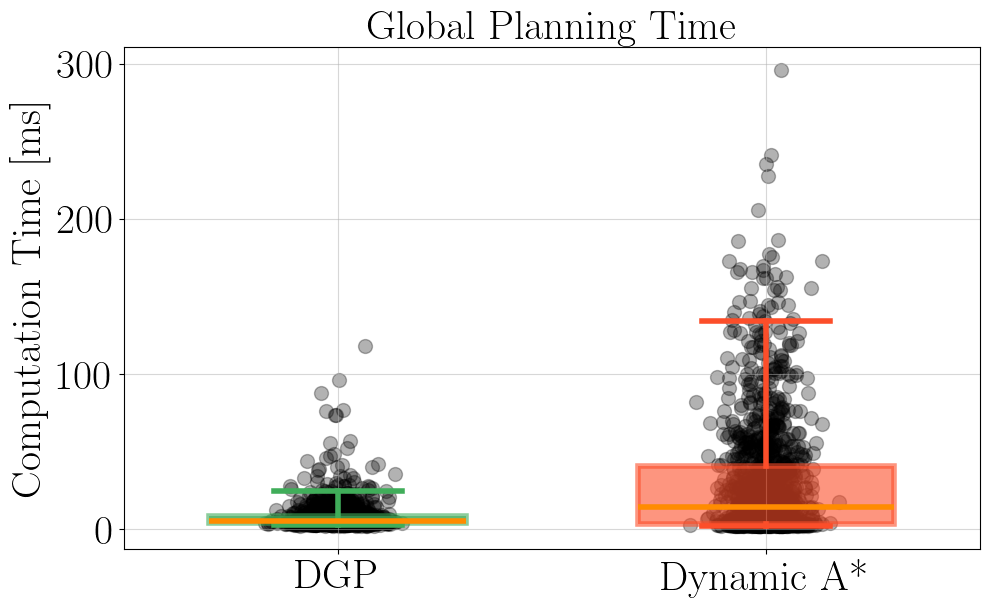

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define font properties (modify as needed)
from matplotlib import font_manager
font = {
    'family': 'Arial',
    'weight': 'normal',
    'size': 30,
}

# List of algorithms and corresponding colors
algorithms = ["dgp", "dastar"]
parent_folder_path = "/media/kkondo/T7/dynus/tro_paper/yaw_optimization/success/"
dgp_color = "#40AD5A"
dastar_color = "#FC4E2A"

# The header to plot
header_to_plot = "Global Planning Time [ms]"

# Create the figure
figsize_x = 10
figsize_y = figsize_x / 1.618  # Golden ratio
fig, ax_box = plt.subplots(figsize=(figsize_x, figsize_y))

# This index will denote x-axis positions (starting at 1 to help with tick labels)
idx = 1
algorithm_labels = []  # To store labels for the x-axis

for algorithm in algorithms:
    if algorithm == "dgp":
        folder_path = os.path.join(parent_folder_path, "dgp/csv/")
        color = dgp_color
        label = "DGP"
    elif algorithm == "dastar":
        folder_path = os.path.join(parent_folder_path, "dastar/csv/")
        color = dastar_color
        label = "Dynamic A*"
    
    # Get and filter data (ensure these functions are defined in your code)
    float_data = get_data(folder_path, "dynus")
    float_data = filter_data(float_data)
    headers = list(float_data.keys())
    
    # Look for the header that matches the target header
    for i in range(1, len(headers)):  # Adjusted for your simulated data structure
        if headers[i] == header_to_plot:
            data_points = float_data[headers[i]]
            # Create boxplot with original whisker settings
            # Note: omitting 'vert=False' uses the default vertical orientation
            box = ax_box.boxplot(
                data_points,
                positions=[idx],
                widths=0.6,
                patch_artist=True,
                showfliers=False,
                whis=[3, 97]
            )
            for element in ['whiskers', 'fliers', 'means', 'caps']:
                plt.setp(box[element], color=color, linewidth=4)
            for patch in box['boxes']:
                patch.set(facecolor=color, alpha=0.6)
                patch.set(color=color, linewidth=4, edgecolor=color)
            for median_line in box['medians']:
                median_line.set_color('darkorange')  # Median line color
                median_line.set_linewidth(4)  # Thicker median line

            # Add jittered data points for additional visualization (jitter horizontally)
            jitter = np.random.normal(0, 0.05, len(data_points))  # Small random offset for x-axis
            ax_box.scatter(idx + jitter, data_points, color='black', alpha=0.3, s=100)
            
            # Save the label for the tick and move to next position
            algorithm_labels.append(label)
            idx += 1

# Set x-axis ticks using the algorithm labels
ax_box.set_xticks(range(1, len(algorithm_labels) + 1))
ax_box.set_xticklabels(algorithm_labels, fontproperties=font)
# ax_box.set_xlabel("Algorithm", fontproperties=font)
ax_box.tick_params(axis='y', labelsize=font['size'])
ax_box.set_ylabel("Computation Time [ms]", fontproperties=font)
ax_box.set_title("Global Planning Time", fontproperties=font)
ax_box.grid(alpha=0.5)

plt.tight_layout()
# plt.show()

# save the figure
output_folder_name = "/media/kkondo/T7/dynus/tro_paper/yaw_optimization/success/figs/"
os.makedirs(output_folder_name, exist_ok=True)
plt.savefig(os.path.join(output_folder_name, "global_planner_benchmark_boxplot.pdf"), bbox_inches='tight', pad_inches=0.1)
